# Information Criterion<br><sub>and Model Selection continued</sub>


In [112]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from scipy import integrate
import seaborn as sns
import pandas as pd
from scipy.stats import norm
from scipy.stats import rankdata
import pytensor.tensor as pt
from scipy.stats import expon, multivariate_normal, norm
from sklearn.preprocessing import StandardScaler

# Week 12 Homework (10)

# Q1: define 

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

Stochastic Process: 
* set of random variables ordered by time/space
* the stochastic process follows a probabilistic rule
* it describes how values change over time. 
* Markov chain is a stochastic process because it involves random variables that go through time steps and each state is random but the transition step is from a set probability rule.
* this is used to model things that change randomly over time (stocks, weather, ...)

Gaussian Process (GP): 
* a type of stochastic process
* for any finite set of points, the corresponding output follows MVN distr
* mean function: gives Exp output for each input
* cov / kernel: measures how related outputs are given inputs
* used for nonparametric regression (time series,...)


Variational Inference with ELBO:
* method for approximating complex posterior distributions
* by using a more simple distrubution rather than the true post
* done by minimizing Kullback-Leibler(KL) divergence
* by maximizing Evidence Lower Bound (ELBO): E_ (ln (p_theta(x,z) / q_phi (z|x)) 
* it balances likelihood and model complexity with KL
* use this when dataset is big or multiple parameters since it's faster than MCMC, when it's ok to use approximate posterior over true for, for neural networks


# Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

In [152]:
df1 = pd.read_csv("austin_weather.csv")
#df1[['DewPointAvgF', 'HumidityAvgPercent', 'WindAvgMPH', 'PrecipitationSumInches']] = df1[['DewPointAvgF', 'HumidityAvgPercent', 'WindAvgMPH', 'PrecipitationSumIn
df1 = df1[["Date", "TempAvgF"]].dropna()
df1["Date"] = pd.to_datetime(df1["Date"])
df1 = df1.sort_values("Date").tail(300)

x = (df1["Date"] - df1["Date"].min()).dt.days.values
y = df1["TempAvgF"].values

x = (x - x.mean()) / x.std()
X = x[:, None]


In [144]:
# GP model
with pm.Model() as gp_model:
    length_scale = pm.Gamma("length_scale", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sigma=5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=length_scale)
    gp = pm.gp.Marginal(cov_func=cov)
    sigma = pm.HalfNormal("sigma", sigma=5)
    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, sigma=sigma)
    gp_idata = pm.sample(draws=300, tune=300, chains=1, cores=1, target_accept=0.9)

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [length_scale, eta, sigma]


Sampling 1 chain for 300 tune and 300 draw iterations (300 + 300 draws total) took 88 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [145]:
# Prediction
X_new = np.linspace(X.min(), X.max(), 200)[:, None]
point = {
    "length_scale": gp_idata.posterior["length_scale"].mean().item(),
    "eta": gp_idata.posterior["eta"].mean().item(),
    "sigma": gp_idata.posterior["sigma"].mean().item()
}
with gp_model:
    mu, var = gp.predict(X_new, point=point, diag=True)

array([[<Axes: title={'center': 'eta'}>, <Axes: title={'center': 'eta'}>],
       [<Axes: title={'center': 'length_scale'}>,
        <Axes: title={'center': 'length_scale'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

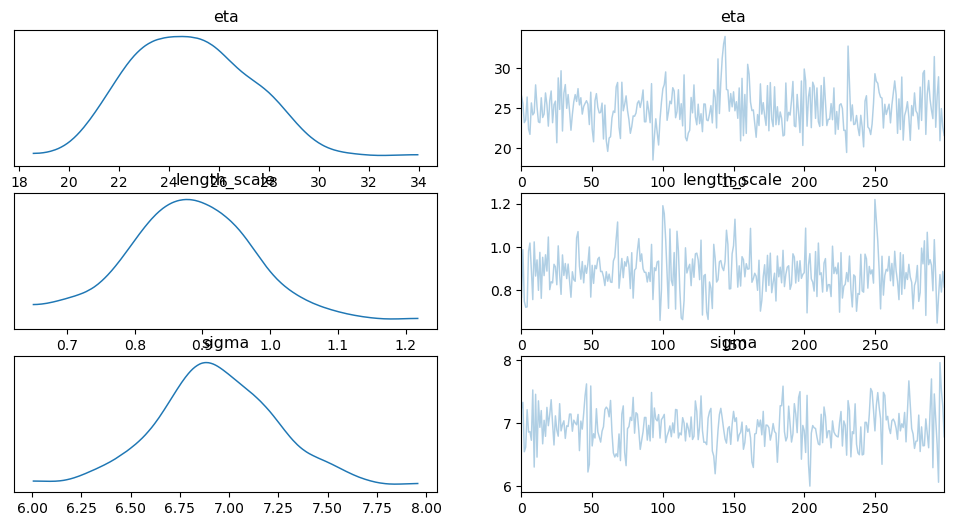

In [148]:
az.plot_trace(gp_idata)

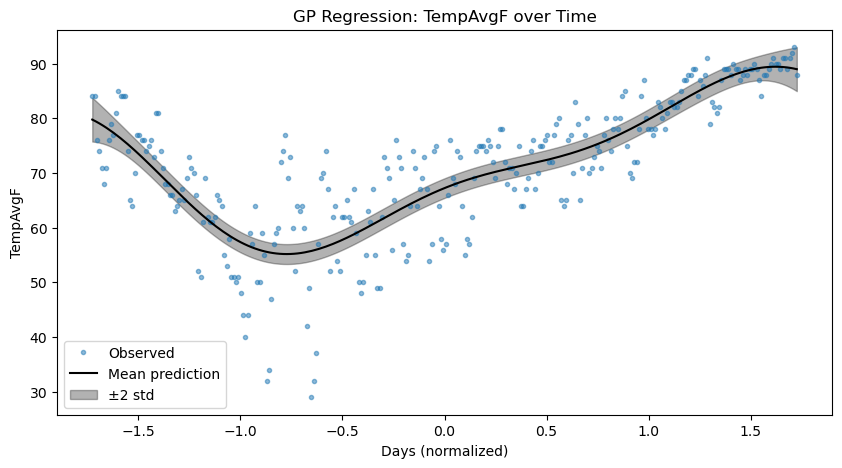

In [146]:
sd = np.sqrt(var)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(X, y, "C0.", alpha=0.5, label="Observed")
plt.plot(X_new, mu, "k", label="Mean prediction")
plt.fill_between(X_new.flatten(), mu - 2 * sd, mu + 2 * sd, color="k", alpha=0.3, label="±2 std")
plt.legend()
plt.title("GP Regression: TempAvgF over Time")
plt.xlabel("Days (normalized)")
plt.ylabel("TempAvgF")
plt.show()

GP
* x as time, y as TempAvgF
* x = (x - x.mean()) / x.std() so the x axis looks like this - this transformed the day values to have mean=0 so 0 is the average date, and <0 is days before and >0 is days after
* GP captured seasonl trends in temperature
* the grey shade area is for visualizing uncertainty and it gets narrower when theres more data points (more confidnece)

# Q3: more VI/ELBO
Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.

In [158]:
# use same data as Q2
y = (y - y.mean()) / y.std()

In [155]:
with pm.Model() as vi_nn:
    w0 = pm.Normal("w0", 0, 1, shape=(1, 10))
    b0 = pm.Normal("b0", 0, 1, shape=(10,))
    h = pt.tanh(pm.math.dot(X, w0) + b0)

    w1 = pm.Normal("w1", 0, 1, shape=(10, 1))
    b1 = pm.Normal("b1", 0, 1)
    mu = pm.math.dot(h, w1) + b1

    sigma = pm.HalfNormal("sigma", 5)
    y_obs = pm.Normal("y_obs", mu=mu.flatten(), sigma=sigma, observed=y)

    approx = pm.fit(n=30000)
    idata_vi = approx.sample(500)

Finished [100%]: Average Loss = 371.56


array([[<Axes: title={'center': 'b0'}>, <Axes: title={'center': 'b0'}>],
       [<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b1'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'w0'}>, <Axes: title={'center': 'w0'}>],
       [<Axes: title={'center': 'w1'}>, <Axes: title={'center': 'w1'}>]],
      dtype=object)

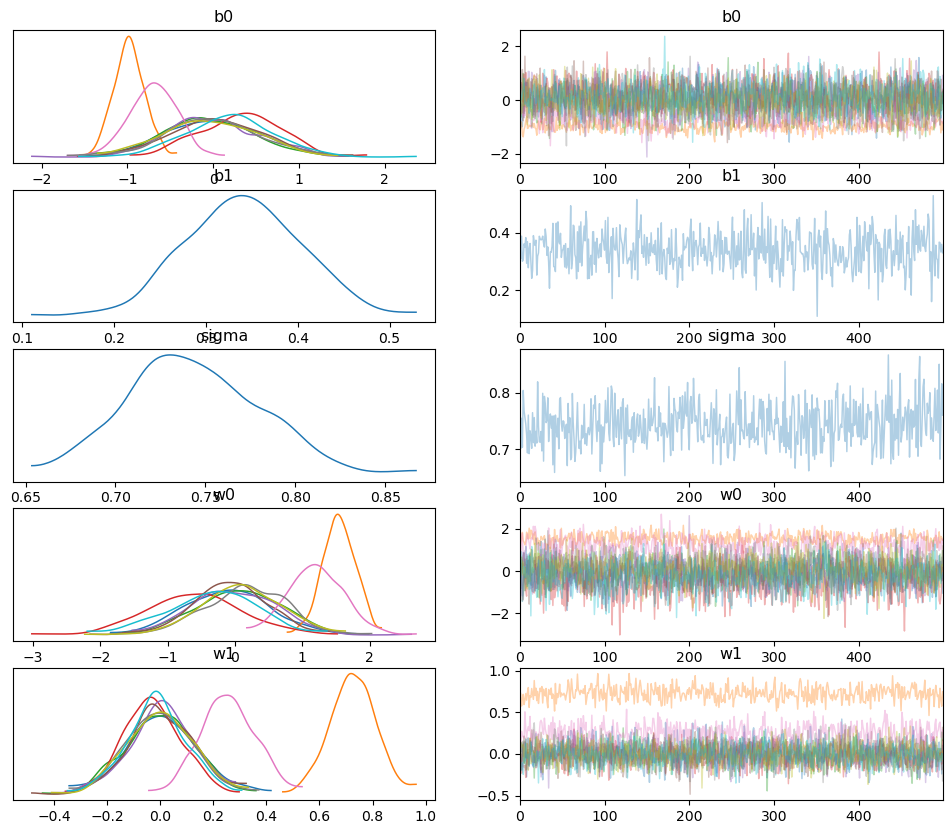

In [157]:
az.plot_trace(idata_vi)

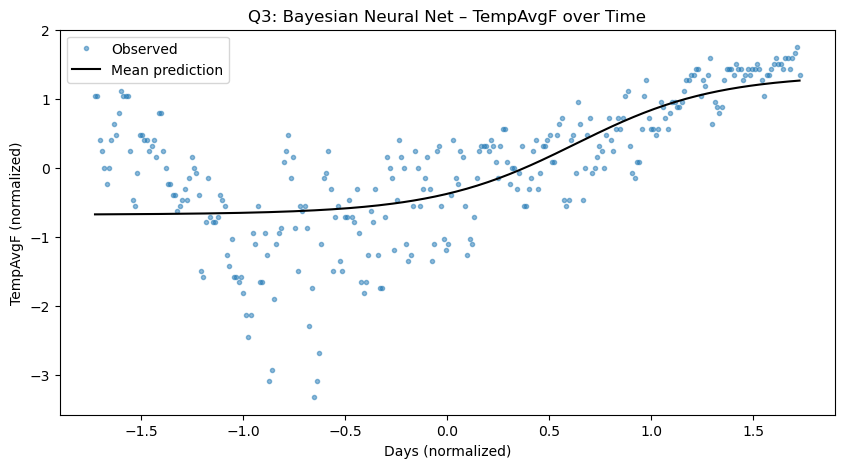

In [156]:
# Cell 3: NN prediction and plot
X_new = np.linspace(X.min(), X.max(), 200)[:, None]
posterior = idata_vi.posterior.stack(sample=("chain", "draw"))
w0 = posterior["w0"].mean("sample").values
b0 = posterior["b0"].mean("sample").values
w1 = posterior["w1"].mean("sample").values
b1 = posterior["b1"].mean("sample").values.item()

h = np.tanh(X_new @ w0 + b0)
mu_pred = (h @ w1 + b1).flatten()

plt.figure(figsize=(10, 5))
plt.plot(X, y, "C0.", alpha=0.5, label="Observed")
plt.plot(X_new, mu_pred, "k", label="Mean prediction")
plt.title("Q3: Bayesian Neural Net – TempAvgF over Time")
plt.xlabel("Days (normalized)")
plt.ylabel("TempAvgF (normalized)")
plt.legend()
plt.show()


VI
* built neural network with one hidden layer
* used normal priors for weights and used tanh
* pm.fit was used to approximate true post
* fit is more stable than GP
* doesn't fit the beginning as well where data is more scattered